In [17]:
from medmnist import PathMNIST
from torchvision.utils import save_image
from torchvision import transforms
from pathlib import Path
import torch

# Image transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Base output directory
base_dir = Path("data")

# Loop through each dataset split
for split in ['train', 'val', 'test']:
    dataset = PathMNIST(split=split, download=True)
    images, labels = dataset.imgs, dataset.labels

    for img, label in zip(images, labels):
        label = int(label[0])  # Extract integer label
        split_dir = base_dir / split / str(label)
        split_dir.mkdir(parents=True, exist_ok=True)

        img_tensor = transform(img)
        filename = f"{torch.randint(0, 1_000_000, (1,)).item()}.png"
        save_image(img_tensor, split_dir / filename)


Using downloaded and verified file: /Users/rohan/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/rohan/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/rohan/.medmnist/pathmnist.npz


In [15]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from medmnist import PathMNIST
from medmnist import INFO

from models.tiny_vgg import TinyVGG
from attacks.fgsm import fgsm_attack


In [16]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28))
])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
val_dataset = PathMNIST(split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

info = INFO['pathmnist']
in_channels = info['n_channels']
num_classes = len(info['label'])

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'


Using downloaded and verified file: /Users/rohan/.medmnist/pathmnist.npz


In [4]:

model = TinyVGG(in_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")


Epoch 1: Loss = 0.9321
Epoch 2: Loss = 0.4708
Epoch 3: Loss = 0.3422
Epoch 4: Loss = 0.2799
Epoch 5: Loss = 0.2299
Epoch 6: Loss = 0.2077
Epoch 7: Loss = 0.1789
Epoch 8: Loss = 0.1506
Epoch 9: Loss = 0.1301
Epoch 10: Loss = 0.1145


In [5]:

def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.squeeze().long().to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
    acc = correct / len(loader.dataset)
    print(f"Accuracy: {acc:.4f}")

evaluate(model, val_loader)


Accuracy: 0.9327


In [6]:

epsilon = 0.2
adv_correct = 0

model.eval()
for images, labels in val_loader:
    images, labels = images.to(device), labels.squeeze().long().to(device)
    adv_images = fgsm_attack(model, images, labels, epsilon)
    outputs = model(adv_images)
    preds = outputs.argmax(1)
    adv_correct += (preds == labels).sum().item()

adv_acc = adv_correct / len(val_loader.dataset)
print(f"Adversarial Accuracy (ε={epsilon}): {adv_acc:.4f}")


Adversarial Accuracy (ε=0.2): 0.0670


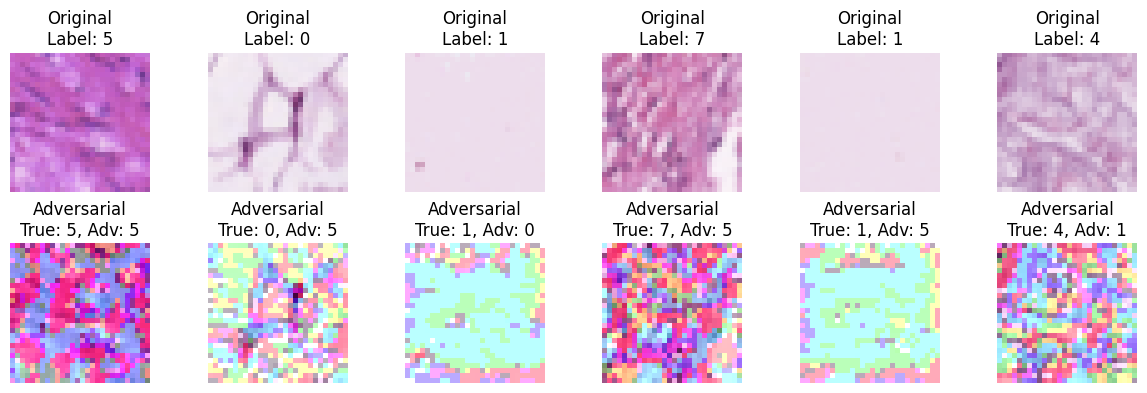

In [11]:
def imshow(img, label, adv_label=None, title=''):
    img = img.squeeze().cpu().detach().numpy()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(img)
    if adv_label is not None:
        plt.title(f'{title}\nTrue: {label}, Adv: {adv_label}')
    else:
        plt.title(f'{title}\nLabel: {label}')
    plt.axis('off')

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.squeeze().long().to(device)

adv_images = fgsm_attack(model, images, labels, epsilon)
preds_clean = model(images).argmax(1)
preds_adv = model(adv_images).argmax(1)

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    imshow(images[i], preds_clean[i].item(), title='Original')
    plt.subplot(2, 6, i+7)
    imshow(adv_images[i], labels[i].item(), preds_adv[i].item(), title='Adversarial')

plt.tight_layout()
plt.show()


In [12]:
torch.save(model.state_dict(), "models/tinyvgg_pathmnist.pth")